In [358]:
import os
import sep
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from iminuit import Minuit
from astropy.io import fits
from astropy.visualization import ImageNormalize, ZScaleInterval, LogStretch

In [237]:
plt.rcParams['figure.figsize'] = (12, 8)

In [240]:
DARK_DIR = '/home/samdixon/darks'

def plot_img(data_or_path):
    if type(data_or_path) is str:
        data = fits.getdata(data_or_path)
    else:
        data = data_or_path
    norm = ImageNormalize(data, ZScaleInterval())
    plt.imshow(data.T, norm=norm)
    plt.colorbar() 
    
def get_data(frame, channel, amp, header=False):
    info = {'frame': frame,
            'channel': channel.upper(),
            'amp': amp}
    fname = '11_133_{frame:03d}_001_25_{channel}.fits'.format(**info)
    path = os.path.join(DARK_DIR, fname)
    data, head = fits.getdata(path, header=True)
    if amp == 0:
        data = np.array(data[:, :1024]).byteswap().newbyteorder()
    else:
        data = np.array(data[:, 1024:]).byteswap().newbyteorder()
    if header:
        return data, head
    return data

def plot_data(frame, channel, amp):
    plt.figure(figsize=(12, 3))
    data = get_data(frame, channel, amp)
    norm = ImageNormalize(data, ZScaleInterval())
    plt.imshow(data.T, norm=norm)
    plt.colorbar()

def get_objs(data):
    bg = sep.Background(data)
    bg_sub_data = data - bg.back()
    objs = sep.extract(bg_sub_data, 1.5, err=bg.globalrms)
    objs = pd.DataFrame.from_records(objs)
    # Remove objects that are flagged
    objs = objs[objs.flag == 0]
    # Ellipticity cut
    objs = objs[1-objs.b/objs.a < 0.2]
    # Avoid objects on the edge of the detector
    objs = objs[(objs.xpeak > 10) & (objs.xpeak < 1014)]
    objs = objs[(objs.ypeak > 10) & (objs.ypeak < 4086)]
    return objs.reset_index()

def get_averages(data, objs):
    averages = []
    for section, subdf in objs.groupby(pd.cut(objs.ypeak, bins=np.linspace(0, 4096, 33))):
        windows = np.array([data[int(obj.ypeak)-10:int(obj.ypeak)+11, int(obj.xpeak)-10:int(obj.xpeak)+11]
                            for _, obj in subdf.iterrows()])
        p_clip_level = np.percentile(windows, 98, axis=0)
        windows[np.where(windows > p_clip_level)] = np.nan
        average = np.nanmean(windows, axis=0)
        averages.append(average)
    return np.array(averages)

def plot_obj(data, obj):
    window = data[int(obj.ypeak)-10:int(obj.ypeak)+11, int(obj.xpeak)-10:int(obj.xpeak)+11]
    norm = ImageNormalize(data, ZScaleInterval())
    plt.figure(figsize=(10, 10))
    plt.imshow(window, norm=norm)
    plt.colorbar()
    
def get_tails(data, objs):
    tails, peak_vals = [], []
    for _, obj in objs.iterrows():
        x = int(obj.xpeak)
        y = int(obj.ypeak)
        tails.append(data[y-10:y, x][::-1]-data[y+1:y+11, x])
        peak_vals.append(data[y, x])
    return np.array(tails), np.array(peak_vals)

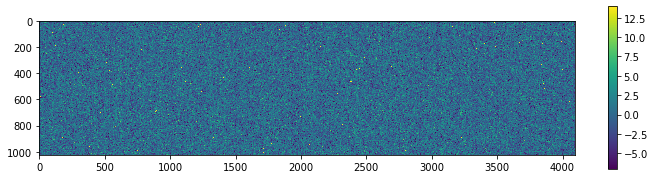

In [241]:
plot_data(4, 'R', 0)

# Gather all tails

In [242]:
all_tails = {'B': {0: {}, 1: {}},
             'R': {0: {}, 1: {}}}
for fname in tqdm(os.listdir(DARK_DIR)):
    frame = int(fname.split('_')[2])
    channel = fname.split('.')[0][-1]
    for amp in (0, 1):
        data = get_data(frame, channel, amp)
        objs = get_objs(data)
        tails, peak_vals = get_tails(data, objs)
        all_tails[channel][amp][frame] = {'tails': tails,
                                          'locs': objs.ypeak,
                                          'peak_vals': peak_vals}

100%|██████████| 302/302 [01:16<00:00,  3.97it/s]


In [335]:
def nmad(arr):
    med = np.median(arr)
    mad = np.median(np.abs(arr-med))
    return 1.4826 * mad

In [353]:
def cte_plot(channel, amp):
    peak_vals = np.concatenate([v['peak_vals'] for k, v in all_tails[channel][amp].items()])
    locs = np.concatenate([v['locs'] for k, v in all_tails[channel][amp].items()])
    tail_counts = np.sum(np.concatenate([v['tails'][:, :9] for k, v in all_tails[channel][amp].items()]), axis=1)
    plt.scatter(locs, tail_counts/peak_vals, s=1, alpha=0.2)
    bins = np.arange(0, 5000, 256)
    median = [np.median((tail_counts/peak_vals)[np.where((locs>bins[i]) & (locs<bins[i+1]))]) for i in range(len(bins)-1)]
    nmads = [nmad((tail_counts/peak_vals)[np.where((locs>bins[i]) & (locs<bins[i+1]))]) for i in range(len(bins)-1)]
    plt.errorbar((bins[1:]+bins[:-1])/2, median,
                 xerr=(bins[1:]-bins[:-1])/2, yerr=nmads,
                 color='C3', linewidth=0, elinewidth=2, marker='o')
    plt.xlim(0, 4096)
    plt.ylim(-1, 1)

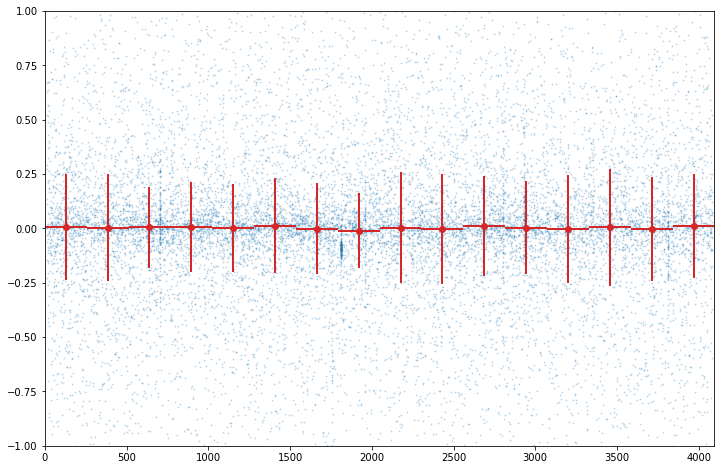

In [357]:
cte_plot('R', 0)

In [371]:
def fit_cte(channel, amp):
    peak_vals = np.concatenate([v['peak_vals'] for k, v in all_tails[channel][amp].items()])
    locs = np.concatenate([v['locs'] for k, v in all_tails[channel][amp].items()])
    tail_counts = np.sum(np.concatenate([v['tails'][:, :4] for k, v in all_tails[channel][amp].items()]), axis=1)
    
    def chisq(m, b):
        line = m * locs + b
        diff = tail_counts/peak_vals - line
        return np.sum(diff**2)
    
    m = Minuit(chisq, pedantic=False,
               m=1e-6, b=0,
               limit_m=(-1, 1), limit_b=(-1, 1))
    m.migrad()
    return np.log10(np.abs(m.values['m']))

In [377]:
fit_cte('R', 1)

FCN = 2749.2433230411707 
 TOTAL NCALL = 38 
 NCALLS = 38 
 
 
 EDM = 5.874768506137032e-11 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,m,2.21817e-06,7.0432e-06,,,-1,1,No
1,b,-0.00503795,0.016268,,,-1,1,No


-5.654005936243747